## Análise de Ameaças Phishing Utilizando Machine Learning

### 1. Bibiliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from plotnine import ggplot, aes, geom_point
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             accuracy_score, f1_score, precision_score, recall_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau


#Configurações
warnings.filterwarnings('ignore')
plt.style.use('ggplot') # Estilo de plotagem R
pd.set_option('display.max_columns', None) # Mostrar todas as colunas


### 2. Importação de dados

In [57]:
df = pd.read_csv('dataset_phishing.csv')

In [58]:
df.shape # Quantidade de linhas e colunas

(11430, 89)

In [59]:
df.head() # Mostrar os primeiros valores do dataset

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,legitimate


### 3. Tratamento e Análise de Dados

In [60]:
# Verificar quantidade de valores faltantes
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [61]:
# Obter variáveis tipo objeto (strings ou dados categóricos)
object_features = [col for col in df.columns if df[col].dtype=="O"]
print(object_features)

['url', 'status']


In [62]:
# Remover url e label encoding da variável status
df = df.drop(labels='url', axis=1)
if 'status' in df.columns:
        df['status'] = df['status'].apply(lambda x: 1 if 'phish' in str(x).lower() else 0)

df.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,0


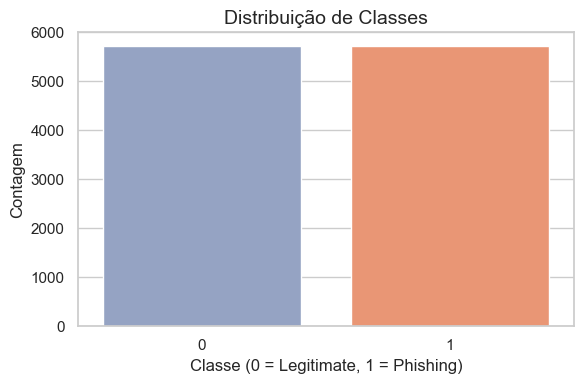

In [63]:
# Distribuição do target
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(6,4))
sns.countplot(x='status', data=df, palette = ['#8da0cb', '#fc8d62'])
plt.title('Distribuição de Classes', fontsize=14)
plt.xlabel('Classe (0 = Legitimate, 1 = Phishing)', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.tight_layout()
plt.show()

In [64]:
# Proteção da variável target antes dos tratamentos
target_col = 'status'
if target_col in df.columns:
    y = df[target_col].copy()  # Salvar a variável target
    X = df.drop(columns=[target_col])  # Features sem o target
    print(f"Variável target '{target_col}' separada.")
else:
    print(f"ATENÇÃO: Variável target '{target_col}' não encontrada!")

df.head()

Variável target 'status' separada.


,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,0


Pares com correlação > 0.7:
                     Var1                Var2  Correlação
2538    longest_words_raw   longest_word_path    0.968503
539                nb_and               nb_eq    0.906404
2576    longest_word_host       avg_word_host    0.816313
2465   shortest_word_host       avg_word_host    0.800014
2946  ratio_intHyperlinks       links_in_tags    0.799374
37             length_url    length_words_raw    0.794710
2612    longest_word_path       avg_word_path    0.791198
2539    longest_words_raw       avg_words_raw    0.784753
180                    ip    ratio_digits_url    0.768906
466                 nb_qm               nb_eq    0.731735
2646        avg_words_raw       avg_word_path    0.729817
2541    longest_words_raw       avg_word_path    0.725344
1704    ratio_digits_host  abnormal_subdomain    0.702772
2610    longest_word_path       avg_words_raw    0.701914


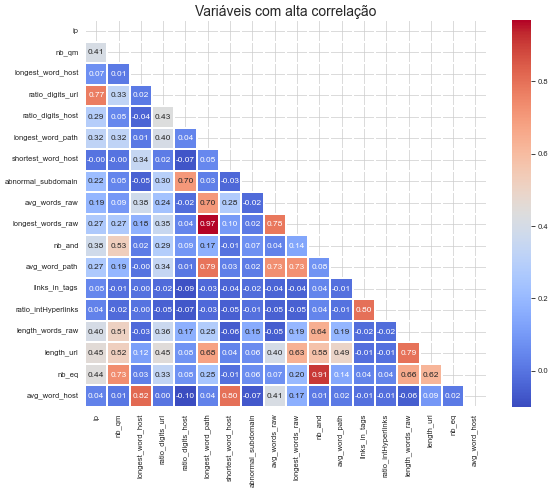

In [65]:
corr_matrix = X.corr().abs() # matriz de correlação das features
high_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
             .stack()
             .reset_index())
high_corr.columns = ['Var1', 'Var2', 'Correlação']
high_corr = high_corr[high_corr['Correlação'] > 0.7].sort_values(by='Correlação', ascending=False)

cols_to_plot = list(set(high_corr['Var1']).union(set(high_corr['Var2'])))
if cols_to_plot:  # Só plotar se houver correlações altas
    corr_matrix1 = X[cols_to_plot].corr()

    # Mostrar os pares
    print("Pares com correlação > 0.7:")
    print(high_corr)

    # Grafico de correlação
    plt.figure(figsize=(12, 10), dpi=50)
    mask = np.triu(np.ones_like(corr_matrix1, dtype=bool))
    sns.heatmap(corr_matrix1, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Variáveis com alta correlação", fontsize=20)
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma correlação > 0.7 encontrada.")

In [66]:
# Remoção da variável do par com alta correlação (maior igual a 0.8): manter a primeira variável de cada par
high_corr = high_corr[high_corr['Correlação']>=0.8]

to_drop = set()
for _, row in high_corr.iterrows():
    if row['Var1'] not in to_drop:
        to_drop.add(row['Var2'])

# Remover as variáveis selecionadas das features (X)
X_reduced = X.drop(columns=to_drop) if to_drop else X.copy()
print(f"Variáveis removidas por alta correlação: {to_drop}")

Variáveis removidas por alta correlação: {'avg_word_host', 'longest_word_path', 'nb_eq'}


Variáveis com alta cardinalidade (>50 valores únicos):
- web_traffic: 4744 valores únicos (Tipo: int64)
- domain_age: 4430 valores únicos (Tipo: int64)
- ratio_extHyperlinks: 3131 valores únicos (Tipo: float64)
- ratio_intHyperlinks: 3131 valores únicos (Tipo: float64)
- domain_registration_length: 1659 valores únicos (Tipo: int64)
- ratio_digits_url: 1414 valores únicos (Tipo: float64)
- safe_anchor: 1083 valores únicos (Tipo: float64)
- avg_words_raw: 896 valores únicos (Tipo: float64)
- ratio_extRedirection: 894 valores únicos (Tipo: float64)
- avg_word_path: 757 valores únicos (Tipo: float64)
- nb_hyperlinks: 691 valores únicos (Tipo: int64)
- ratio_extErrors: 635 valores únicos (Tipo: float64)
- ratio_intMedia: 490 valores únicos (Tipo: float64)
- ratio_extMedia: 490 valores únicos (Tipo: float64)
- links_in_tags: 473 valores únicos (Tipo: float64)
- length_url: 324 valores únicos (Tipo: int64)
- ratio_digits_host: 241 valores únicos (Tipo: float64)
- longest_words_raw: 119 valore

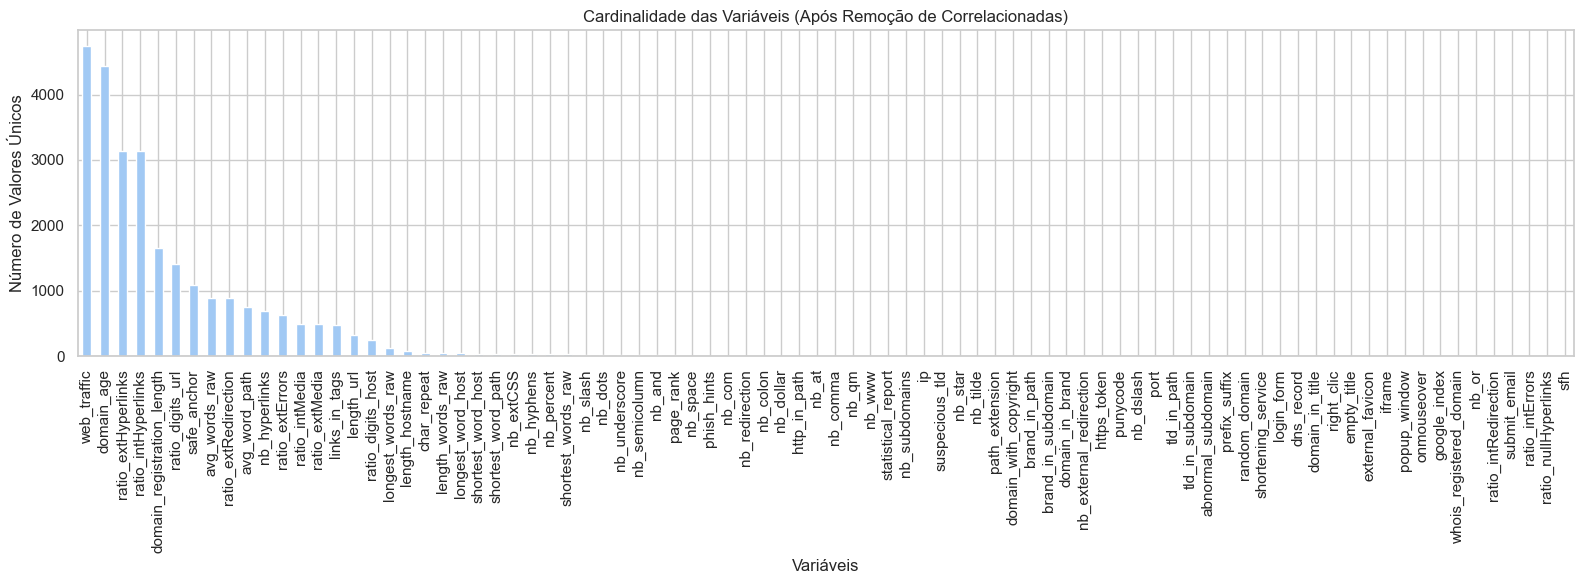

In [67]:
# Calcular cardinalidade após remoção
cardinality = X_reduced.nunique().sort_values(ascending=False)

# Filtrar variáveis com alta cardinalidade
high_card_cols = cardinality[cardinality > 50].index.tolist()
high_card_values = cardinality[cardinality > 50]

print("Variáveis com alta cardinalidade (>50 valores únicos):")
for col, nunique in high_card_values.items():
    dtype = X_reduced[col].dtype
    print(f"- {col}: {nunique} valores únicos (Tipo: {dtype})")

# Gráfico de cardinalidade
plt.figure(figsize=(16, 6))
cardinality.plot(kind='bar')
plt.title('Cardinalidade das Variáveis (Após Remoção de Correlacionadas)')
plt.ylabel('Número de Valores Únicos')
plt.xlabel('Variáveis')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [68]:
# Tratamento de dados para alta cardinalidade
for col in high_card_cols:
    # Contagem de valores antes do tratamento
    original_counts = X_reduced[col].nunique()
    
    # Estratégia: Binagem em 5 categorias usando quantis
    try:
        X_reduced[col] = pd.qcut(X_reduced[col], q=5, duplicates='drop', labels=False)
        new_counts = X_reduced[col].nunique()
        print(f"» {col}: Reduzido de {original_counts} para {new_counts} bins")
    except ValueError as e:
        print(f"» {col}: Não foi possível aplicar binagem - {str(e)}")
        # Alternativa: Transformação logarítmica para distribuições assimétricas
        if (X_reduced[col] > 0).all():
            X_reduced[col] = np.log1p(X_reduced[col])
            print(f"   Aplicada transformação logarítmica alternativa")

» web_traffic: Reduzido de 4744 para 4 bins
» domain_age: Reduzido de 4430 para 5 bins
» ratio_extHyperlinks: Reduzido de 3131 para 4 bins
» ratio_intHyperlinks: Reduzido de 3131 para 5 bins
» domain_registration_length: Reduzido de 1659 para 5 bins
» ratio_digits_url: Reduzido de 1414 para 3 bins
» safe_anchor: Reduzido de 1083 para 4 bins
» avg_words_raw: Reduzido de 896 para 5 bins
» ratio_extRedirection: Reduzido de 894 para 3 bins
» avg_word_path: Reduzido de 757 para 4 bins
» nb_hyperlinks: Reduzido de 691 para 5 bins
» ratio_extErrors: Reduzido de 635 para 2 bins
» ratio_intMedia: Reduzido de 490 para 2 bins
» ratio_extMedia: Reduzido de 490 para 2 bins
» links_in_tags: Reduzido de 473 para 3 bins
» length_url: Reduzido de 324 para 5 bins
» ratio_digits_host: Reduzido de 241 para 1 bins
» longest_words_raw: Reduzido de 119 para 5 bins
» length_hostname: Reduzido de 83 para 5 bins
» char_repeat: Reduzido de 55 para 4 bins
» length_words_raw: Reduzido de 54 para 5 bins


In [69]:
# Removendo variáveis com apenas 1 valor único (constantes)
const_cols  = [col for col in X_reduced.columns if X_reduced[col].nunique() == 1]
X_reduced = X_reduced.drop(columns=const_cols)


Cardinalidade após tratamento:
longest_word_host          49
shortest_word_host         34
shortest_word_path         33
nb_extCSS                  33
nb_hyphens                 27
                           ..
onmouseover                 2
domain_with_copyright       2
whois_registered_domain     2
dns_record                  2
google_index                2
Length: 77, dtype: int64


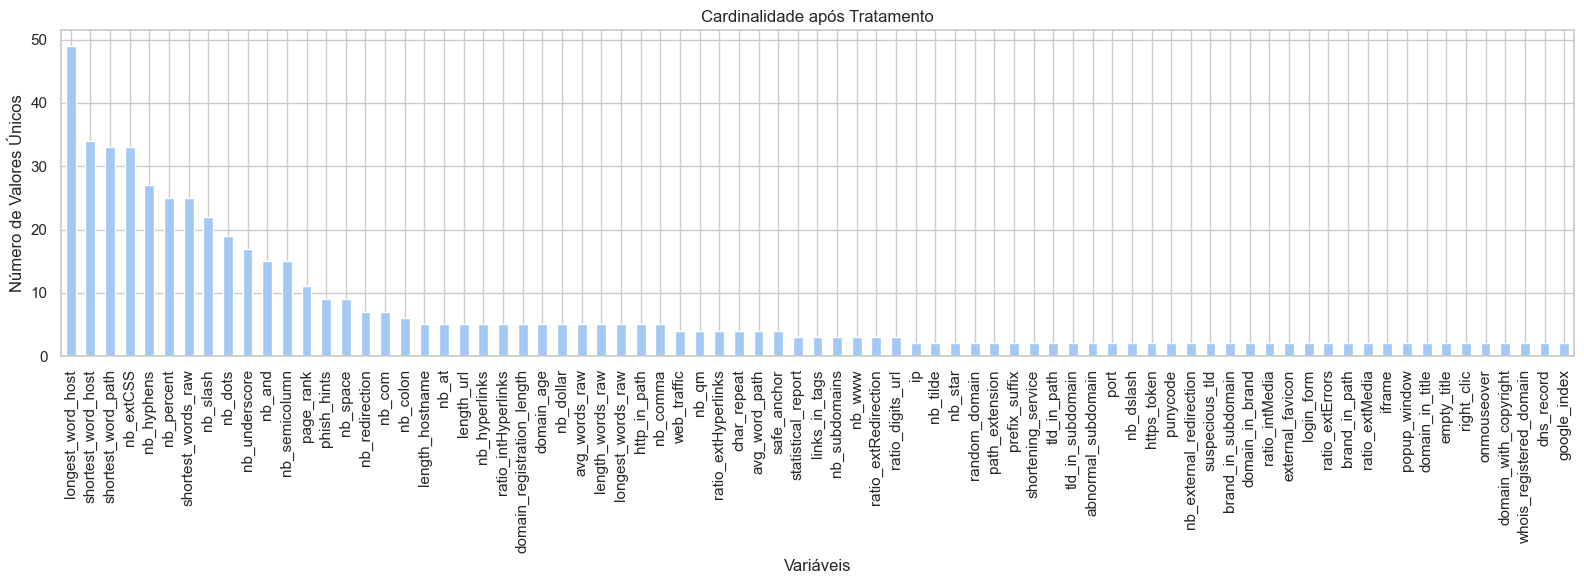

In [70]:
# Nova verificação de cardinalidade
final_cardinality = X_reduced.nunique().sort_values(ascending=False)
print("\nCardinalidade após tratamento:")
print(final_cardinality[final_cardinality > 1])  # Mostrar apenas colunas não-constantes

plt.figure(figsize=(16, 6))
final_cardinality.plot(kind='bar')
plt.title('Cardinalidade após Tratamento')
plt.ylabel('Número de Valores Únicos')
plt.xlabel('Variáveis')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [71]:
# Recombinação: Juntar features tratadas com o target
df_reduced = X_reduced.copy()
df_reduced[target_col] = y  # Adicionar a variável target novamente

print(f"Dataset final: {df_reduced.shape}")
print(f"Variável target '{target_col}' preservada com {df_reduced[target_col].nunique()} classes únicas")
print(f"Distribuição do target:")
print(df_reduced[target_col].value_counts())

df_reduced.head()

Dataset final: (11430, 78)
Variável target 'status' preservada com 2 classes únicas
Distribuição do target:
status
0    5715
1    5715
Name: count, dtype: int64


,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,avg_words_raw,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,nb_extCSS,ratio_extRedirection,ratio_extErrors,login_form,external_favicon,links_in_tags,ratio_intMedia,ratio_extMedia,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,1,2,0,3,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,1,2,3,3,3,2,11,1,1,0,0,0,0,0,0,1,1,2,0,2,1,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,4,0
1,3,3,1,1,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,0,0,0,1,0,1,2,2,19,2,4,19,4,3,0,0,0,0,0,0,2,3,0,0,0,0,0,0,2,1,0,0,0,3,0,0,0,1,0,0,1,3,0,0,1,2,1
2,4,4,1,4,1,0,1,2,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,1,0,3,1,0,0,0,1,0,4,0,2,3,2,3,13,3,3,0,0,0,0,0,0,0,4,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,1,0,0,0,2,3,0,1,0,1
3,0,0,0,2,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,5,5,0,0,5,0,0,0,0,0,0,0,0,4,4,0,0,1,1,0,0,2,1,0,0,0,2,0,0,0,1,0,0,1,0,2,0,0,3,0
4,2,1,0,2,2,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,1,0,2,1,3,3,4,2,7,2,2,0,0,0,0,0,0,3,1,2,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,2,4,1,0,0,6,0


### 4. Preparação Final dos Dados para ML

In [72]:
# Separar features e target
X= df_reduced.iloc[: , 0:-1]
Y= df_reduced['status']

In [73]:
# Separar variáveis binárias
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if col not in binary_cols]

# Escalar apenas as não-binárias
scaler = StandardScaler()
X_scaled_non_binary = pd.DataFrame(scaler.fit_transform(X[non_binary_cols]), columns=non_binary_cols)

# Concatenar com as binárias
X_scaled = pd.concat([X_scaled_non_binary, X[binary_cols]], axis=1)


<Figure size 1400x800 with 0 Axes>

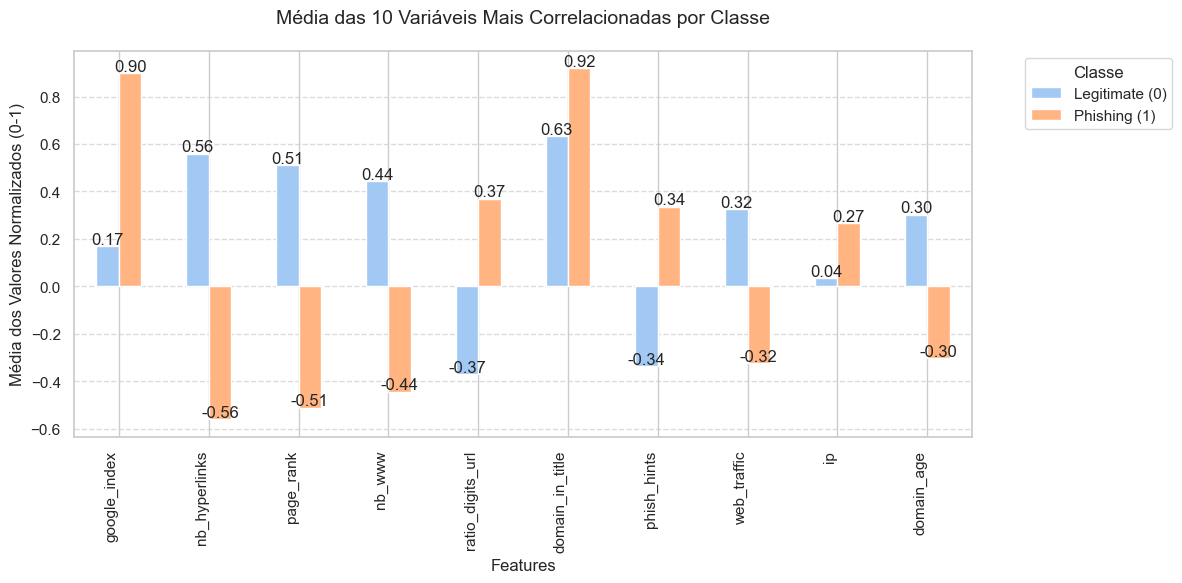

In [74]:
# Visualização das Médias das Features por Classe (Status)

# Criar cópia dos dados normalizados e adicionar a variável target
X_scaled_with_status = X_scaled.copy()
X_scaled_with_status['status'] = y.values

# Selecionar as 10 variáveis mais correlacionadas com o target
top10_corr = X_scaled.corrwith(y).abs().sort_values(ascending=False).head(10)
cols = top10_corr.index.tolist()
cols.append('status')  # Adicionar a coluna status para o groupby

# Calcular a média de cada feature para cada classe
df_grouped = X_scaled_with_status[cols].groupby('status').mean().T
df_grouped.columns = ['Legitimate (0)', 'Phishing (1)']

# Plotar o gráfico de barras comparativo
plt.figure(figsize=(14, 8))
ax = df_grouped.plot(kind='bar', figsize=(12,6))
ax.set_title("Média das 10 Variáveis Mais Correlacionadas por Classe", fontsize=14, pad=20)
ax.set_xlabel("Features", fontsize=12)
ax.set_ylabel("Média dos Valores Normalizados (0-1)", fontsize=12)
ax.legend(title='Classe', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.xticks(rotation=90, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [75]:
#  Treino (60%): ajuste do modelo
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.4, random_state=1, stratify=y
)

# Validação (20%): Ajuste dos hiperparâmetros
# Teste (20%): Avaliação da performance no final
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

print(f"Treino: {X_train.shape}")
print(f"Validação: {X_val.shape}")
print(f"Teste: {X_test_final.shape}")

Treino: (6858, 77)
Validação: (2286, 77)
Teste: (2286, 77)


In [76]:
# Verificar distribuição das classes em cada conjunto
print("\nDistribuição das classes:")
print(f"Treino - Classe 0: {(y_train==0).sum()} ({(y_train==0).mean():.2%}), Classe 1: {(y_train==1).sum()} ({(y_train==1).mean():.2%})")
print(f"Validação - Classe 0: {(y_val==0).sum()} ({(y_val==0).mean():.2%}), Classe 1: {(y_val==1).sum()} ({(y_val==1).mean():.2%})")
print(f"Teste - Classe 0: {(y_test_final==0).sum()} ({(y_test_final==0).mean():.2%}), Classe 1: {(y_test_final==1).sum()} ({(y_test_final==1).mean():.2%})")


Distribuição das classes:
Treino - Classe 0: 3429 (50.00%), Classe 1: 3429 (50.00%)
Validação - Classe 0: 1143 (50.00%), Classe 1: 1143 (50.00%)
Teste - Classe 0: 1143 (50.00%), Classe 1: 1143 (50.00%)


### 5. Definição e Treinamento dos Modelos de Machine Learning

In [77]:
# Dicionário para armazenar os modelos e resultados
models = {}
results = {}


def evaluate_model(model, X, y, model_name):
    """
    Avalia um modelo e retorna métricas de performance
    """
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }

    scores = cross_validate(model, X, y, scoring=scoring, cv=5, return_train_score=True)
    
    metrics = {
        'train_accuracy': scores['train_accuracy'].mean(),
        'val_accuracy': scores['test_accuracy'].mean(),
        'train_precision': scores['train_precision'].mean(),
        'val_precision': scores['test_precision'].mean(),
        'train_recall': scores['train_recall'].mean(),
        'val_recall': scores['test_recall'].mean(),
        'train_f1': scores['train_f1'].mean(),
        'val_f1': scores['test_f1'].mean(),
        'train_auc': scores['train_roc_auc'].mean(),
        'val_auc': scores['test_roc_auc'].mean(),
    }
    
    return metrics


In [78]:
# Logistic Regression
print("Treinando Logistic Regression")
lr_model = LogisticRegression(random_state=1, max_iter=1000)
models['Logistic Regression'] = lr_model
results['Logistic Regression'] = evaluate_model(lr_model, X_train, y_train, 'Logistic Regression')
print("Logistic Regression concluído")

Treinando Logistic Regression
Logistic Regression concluído


In [79]:
# K-Nearest Neighbors (KNN)
print("Treinando KNN")
knn_model = KNeighborsClassifier(n_neighbors=5)
models['KNN'] = knn_model
results['KNN'] = evaluate_model(knn_model, X_train, y_train, 'KNN')
print("KNN concluído")


Treinando KNN
KNN concluído


In [80]:
# Random Forest
print("Treinando Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=100, # número de árvores na floresta (padrão: 100)
    random_state=1,
    n_jobs=-1
)
models['Random Forest'] = rf_model
results['Random Forest'] = evaluate_model(rf_model, X_train, y_train, 'Random Forest')
print("Random Forest concluído")

Treinando Random Forest
Random Forest concluído


In [81]:
# XGBoost
print("Treinando XGBoost")
xgb_model = XGBClassifier(
    random_state=1,
    eval_metric='logloss',  #  métrica de avaliação usada durante o treino ('logloss' para classificação binária)
    verbosity=0
)
models['XGBoost'] = xgb_model
results['XGBoost'] = evaluate_model(xgb_model, X_train, y_train, 'XGBoost')
print("XGBoost concluído")

Treinando XGBoost
XGBoost concluído


In [82]:
# Support Vector Machine
print("Treinando SVM")
svm_model = SVC(
    random_state=1,
    probability=True  # Para obter probabilidades
)
models['SVM'] = svm_model
results['SVM'] = evaluate_model(svm_model, X_train, y_train, 'SVM')
print("SVM concluído")

Treinando SVM
SVM concluído


In [83]:
lgb_model = lgb.LGBMClassifier(
    random_state=1,
    verbose=-1,
    n_jobs=-1)
models['LightGBM'] = lgb_model
results['LightGBM'] = evaluate_model(lgb_model, X_train, y_train, 'LightGBM')
print("LightGBM concluído")


LightGBM concluído


In [84]:
# Uma camada intermediárias com 100 neurônios
mlp_model = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=500, random_state=1)
models['MLP'] = mlp_model
results['MLP'] = evaluate_model(mlp_model, X_train, y_train, 'MLP')
print("MLP concluído")


MLP concluído


In [85]:
# Duas camadas intermediárias com 100 e 50 neurônios
mlp_model1 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500,  early_stopping=False, verbose=True, random_state=1)
models['MLP1'] = mlp_model1
results['MLP1'] = evaluate_model(mlp_model1, X_train, y_train, 'MLP1')
print("MLP1 concluído")

Iteration 1, loss = 0.47369178
Iteration 2, loss = 0.24362102
Iteration 3, loss = 0.17563561
Iteration 4, loss = 0.14718324
Iteration 5, loss = 0.12982957
Iteration 6, loss = 0.11813028
Iteration 7, loss = 0.10988516
Iteration 8, loss = 0.10351698
Iteration 9, loss = 0.09781874
Iteration 10, loss = 0.09272472
Iteration 11, loss = 0.08721946
Iteration 12, loss = 0.08398202
Iteration 13, loss = 0.07908549
Iteration 14, loss = 0.07584901
Iteration 15, loss = 0.07049440
Iteration 16, loss = 0.06629331
Iteration 17, loss = 0.06277487
Iteration 18, loss = 0.05920145
Iteration 19, loss = 0.05733973
Iteration 20, loss = 0.05321876
Iteration 21, loss = 0.05127943
Iteration 22, loss = 0.04706369
Iteration 23, loss = 0.04388423
Iteration 24, loss = 0.04245292
Iteration 25, loss = 0.03807634
Iteration 26, loss = 0.03625999
Iteration 27, loss = 0.03436484
Iteration 28, loss = 0.03287887
Iteration 29, loss = 0.03095289
Iteration 30, loss = 0.02626792
Iteration 31, loss = 0.02507707
Iteration 32, los

In [86]:
# Compilar resultados em DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df)

                     train_accuracy  val_accuracy  train_precision  \
Logistic Regression          0.9461        0.9421           0.9487   
KNN                          0.9555        0.9318           0.9654   
Random Forest                1.0000        0.9609           1.0000   
XGBoost                      1.0000        0.9628           1.0000   
SVM                          0.9731        0.9583           0.9769   
LightGBM                     0.9990        0.9647           0.9993   
MLP                          1.0000        0.9549           1.0000   
MLP1                         1.0000        0.9530           1.0000   

                     val_precision  train_recall  val_recall  train_f1  \
Logistic Regression         0.9430        0.9432      0.9411    0.9459   
KNN                         0.9442        0.9450      0.9178    0.9550   
Random Forest               0.9623        0.9999      0.9595    1.0000   
XGBoost                     0.9616        1.0000      0.9641    1.0000   

In [87]:
# Identificar o melhor modelo baseado no F1-Score de validação
best_model_name = results_df['val_f1'].idxmax()
best_model = models[best_model_name]
best_f1 = results_df.loc[best_model_name, 'val_f1']

print(f"Melhor modelo: {best_model_name}")
print(f"F1-Score de Validação: {best_f1:.4f}")

Melhor modelo: LightGBM
F1-Score de Validação: 0.9648


In [88]:
# Ajuste dos hiperparâmetros para o melhor modelo 

param_grid = {
    'n_estimators': [50, 100, 200],     # Número de árvores na floresta
    'max_depth': [3, 5, 7],             # Profundidade máxima das árvores
    'learning_rate': [0.01, 0.1, 0.2]   # Taxa de aprendizado
}

# Inicializa o modelo LightGBM
lgbm = lgb.LGBMClassifier(
    random_state=1,
    verbose=-1,
    n_jobs=-1
    )

# Grid Search com validação cruzada (5 folds) para otimizar F1-score
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor F1 (cv):", grid_search.best_score_)

# Avaliar no conjunto de validação usando o melhor modelo encontrado
best_model = grid_search.best_estimator_
val_preds = best_model.predict(X_val)
val_f1 = f1_score(y_val, val_preds)
print(f"F1 no conjunto de validação: {val_f1:.4f}")

Melhores hiperparâmetros: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Melhor F1 (cv): 0.9641323757210974
F1 no conjunto de validação: 0.9682


In [89]:
best_model

LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=200, n_jobs=-1,
               random_state=1, verbose=-1)

In [90]:
# Avaliação final

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

best_model.fit(X_trainval, y_trainval)
test_preds = best_model.predict(X_test_final)
test_f1 = f1_score(y_test_final, test_preds)
print(f"F1 no teste final: {test_f1:.4f}")


F1 no teste final: 0.9742


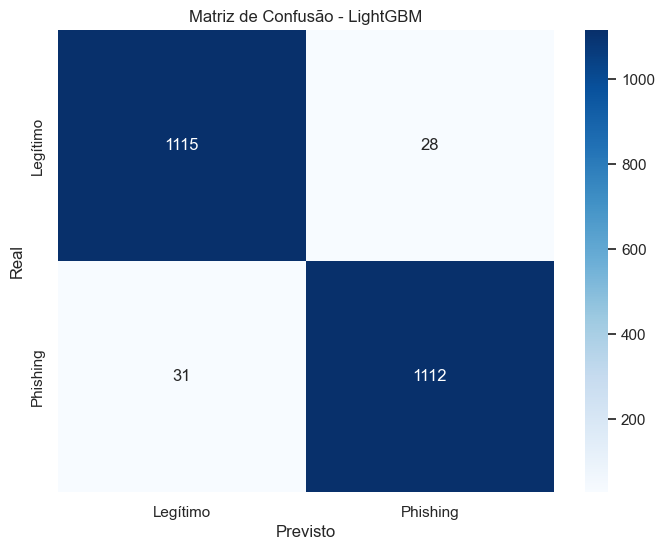

In [91]:
# Matriz de confusão 
cm = confusion_matrix(y_test_final, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legítimo', 'Phishing'], yticklabels=['Legítimo', 'Phishing'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

### 6. Redes neurais com TensorFlow/Keras

In [97]:
# Rene neural com 3 camadas 
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)), 
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Rene neural com 3 camadas com BatchNormalization e Dropout
def create_model1():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])
    return model



model_nn = create_model1()

model_nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,073 (74.50 KB)

 Trainable params: 18,689 (73.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [101]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.5,
    min_lr=1e-5,
    verbose=1
)


history = model_nn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_reduction],
    verbose=2
)

# Avaliação usando o conjunto de validação

val_preds_nn = model_nn.predict(X_val)
val_preds_labels = (val_preds_nn > 0.5).astype(int)

f1 = f1_score(y_val, val_preds_labels)
auc = roc_auc_score(y_val, val_preds_nn)
print(f'F1-Score (val): {f1:.4f}')
print(f'AUC (val): {auc:.4f}')


Epoch 1/100
215/215 - 1s - 4ms/step - accuracy: 0.9721 - auc: 0.9958 - loss: 0.0755 - val_accuracy: 0.9633 - val_auc: 0.9927 - val_loss: 0.1009 - learning_rate: 2.5000e-04
Epoch 2/100
215/215 - 1s - 4ms/step - accuracy: 0.9742 - auc: 0.9961 - loss: 0.0745 - val_accuracy: 0.9637 - val_auc: 0.9928 - val_loss: 0.1011 - learning_rate: 2.5000e-04
Epoch 3/100
215/215 - 1s - 3ms/step - accuracy: 0.9727 - auc: 0.9966 - loss: 0.0717 - val_accuracy: 0.9628 - val_auc: 0.9929 - val_loss: 0.1029 - learning_rate: 2.5000e-04
Epoch 4/100
215/215 - 1s - 3ms/step - accuracy: 0.9762 - auc: 0.9972 - loss: 0.0644 - val_accuracy: 0.9637 - val_auc: 0.9928 - val_loss: 0.1025 - learning_rate: 2.5000e-04
Epoch 5/100
215/215 - 1s - 3ms/step - accuracy: 0.9738 - auc: 0.9960 - loss: 0.0727 - val_accuracy: 0.9641 - val_auc: 0.9922 - val_loss: 0.1019 - learning_rate: 2.5000e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
215/215 - 1s - 3ms/step - accuracy: 0.9774 - auc: 0

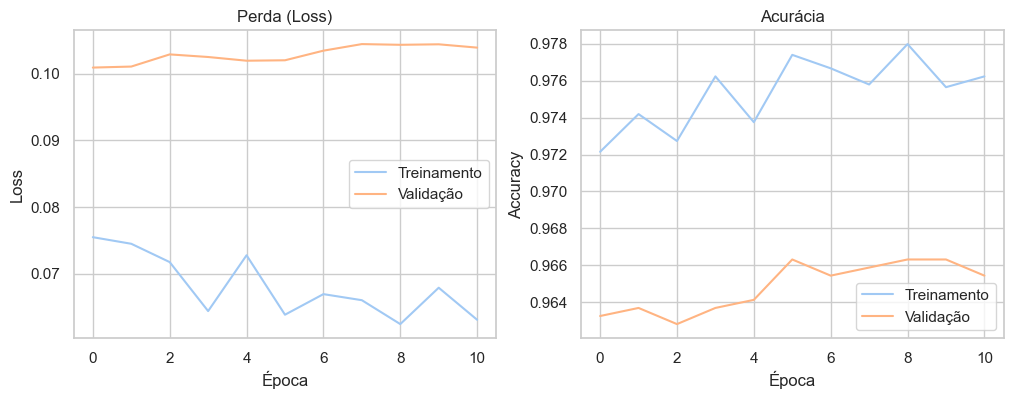

In [105]:
# Acompanhar loss e accuracy (ou outra métrica que você usa) no treino e validação ao longo das épocas, para detectar overfitting

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [108]:
# Treinar o modelo final com treino + validação juntos

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

model_nn_final = create_model1()
model_nn_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model_nn_final.fit(
    X_trainval, y_trainval,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)



test_preds_nn = model_nn_final.predict(X_test_final)
test_preds_labels = (test_preds_nn > 0.5).astype(int)

test_f1 = f1_score(y_test_final, test_preds_labels)
test_auc = roc_auc_score(y_test_final, test_preds_nn)



Epoch 1/100
286/286 - 5s - 17ms/step - accuracy: 0.8892 - loss: 0.2732
Epoch 2/100
286/286 - 1s - 2ms/step - accuracy: 0.9366 - loss: 0.1760
Epoch 3/100
286/286 - 1s - 2ms/step - accuracy: 0.9407 - loss: 0.1641
Epoch 4/100
286/286 - 1s - 2ms/step - accuracy: 0.9447 - loss: 0.1534
Epoch 5/100
286/286 - 1s - 2ms/step - accuracy: 0.9513 - loss: 0.1416
Epoch 6/100
286/286 - 1s - 2ms/step - accuracy: 0.9536 - loss: 0.1291
Epoch 7/100
286/286 - 1s - 2ms/step - accuracy: 0.9529 - loss: 0.1306
Epoch 8/100
286/286 - 1s - 2ms/step - accuracy: 0.9569 - loss: 0.1248
Epoch 9/100
286/286 - 1s - 2ms/step - accuracy: 0.9560 - loss: 0.1250
Epoch 10/100
286/286 - 1s - 2ms/step - accuracy: 0.9581 - loss: 0.1131
Epoch 11/100
286/286 - 1s - 2ms/step - accuracy: 0.9582 - loss: 0.1121
Epoch 12/100
286/286 - 1s - 2ms/step - accuracy: 0.9615 - loss: 0.1096
Epoch 13/100
286/286 - 1s - 2ms/step - accuracy: 0.9614 - loss: 0.1092
Epoch 14/100
286/286 - 1s - 2ms/step - accuracy: 0.9628 - loss: 0.1058
Epoch 15/100
2

In [109]:
print(f"F1 no teste final: {test_f1:.4f}")
print(f"AUC no teste final: {test_auc:.4f}")

F1 no teste final: 0.9668
AUC no teste final: 0.9928
